### Notebook for plotting epochs based on behaviour (movement/non-movement)

In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from mne.time_frequency import psd_array_multitaper

from settings_general import *
from shared.helper_functions import *

Change plot theme

In [2]:
sns.set_theme()

Select data folders

In [3]:
epoch_folder = select_folder("Select the folder that holds epoch files starting with 'filtered_epochs_w_movement'")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

Let's load the epoch object

In [4]:
# let's load the epochs file
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    subj_id = file.split('_')[-1].split('-')[0]
    if not file.startswith('filtered_epochs_w_movement'):
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

In [5]:
len(all_subject_epochs)

18

In [35]:
n_mov = 0
n_non_mov = 0
for file in all_subject_epochs:
    n_mov += len(file[file.metadata['movement'] == True])
    n_non_mov += len(file[file.metadata['movement'] == False])
    
print(n_mov / (n_mov + n_non_mov))
print(n_non_mov / (n_mov + n_non_mov))

39489
39508
78211
78227
78233
78244
79592
79593
79602
79604
80620
80625
80630
81175
81193
81207
81217
81218
0.7697868004690774
0.2302131995309226


In [37]:
print(n_mov, n_non_mov, n_mov + n_non_mov)

40042 11975 52017


Get the names of the channels we want to plot

In [6]:
wanted_chans = [channel for channel in all_subject_epochs[0].info["ch_names"] if not channel in ['EMG_L', 'EMG_R']]
wanted_chans

['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R']

#### DRD2-WT and DRD2-KO average PSD for movement and non-movement epochs

First, let's create a dataframe that holds all PSD means per subject, and is annotated with the genotype of the subject

In [7]:
df = pd.DataFrame()

for i, channel in enumerate(wanted_chans):
    
    for subject_epochs in all_subject_epochs:
        subject_epochs = subject_epochs[:-1]  # last epoch doesn't contain data

        subject_id = int(subject_epochs.metadata["animal_id"].iloc[0])
        genotype = subject_epochs.metadata["genotype"].iloc[0]

        for beh in subject_epochs.metadata.movement.unique():
            beh_epochs = subject_epochs[subject_epochs.metadata["movement"] == beh]
    
            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                beh_epochs.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=beh_epochs.info['sfreq'],
                n_jobs=6,
                normalization='full',
                verbose='WARNING'
            )
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]
            
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
    
            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "behaviour": "movement" if beh == 1 else "non-movement"
            })])
        
    print(f"Done with channel {channel}.")

Done with channel OFC_R.
Done with channel OFC_L.
Done with channel CG.
Done with channel STR_R.
Done with channel S1_L.
Done with channel S1_R.
Done with channel V1_R.


Let's remove all non-quality channels/subjects (see rest_psd_analysis notebook on why)

In [8]:
df = df[df.subject_id != 81217]
df = df[~((df.subject_id == 81193) & (df.channel == 'OFC_R'))]
df = df[~((df.subject_id == 39489) & (df.channel == 'OFC_R'))]
df = df[df.subject_id != 79604]

Now let's plot the normalized powers

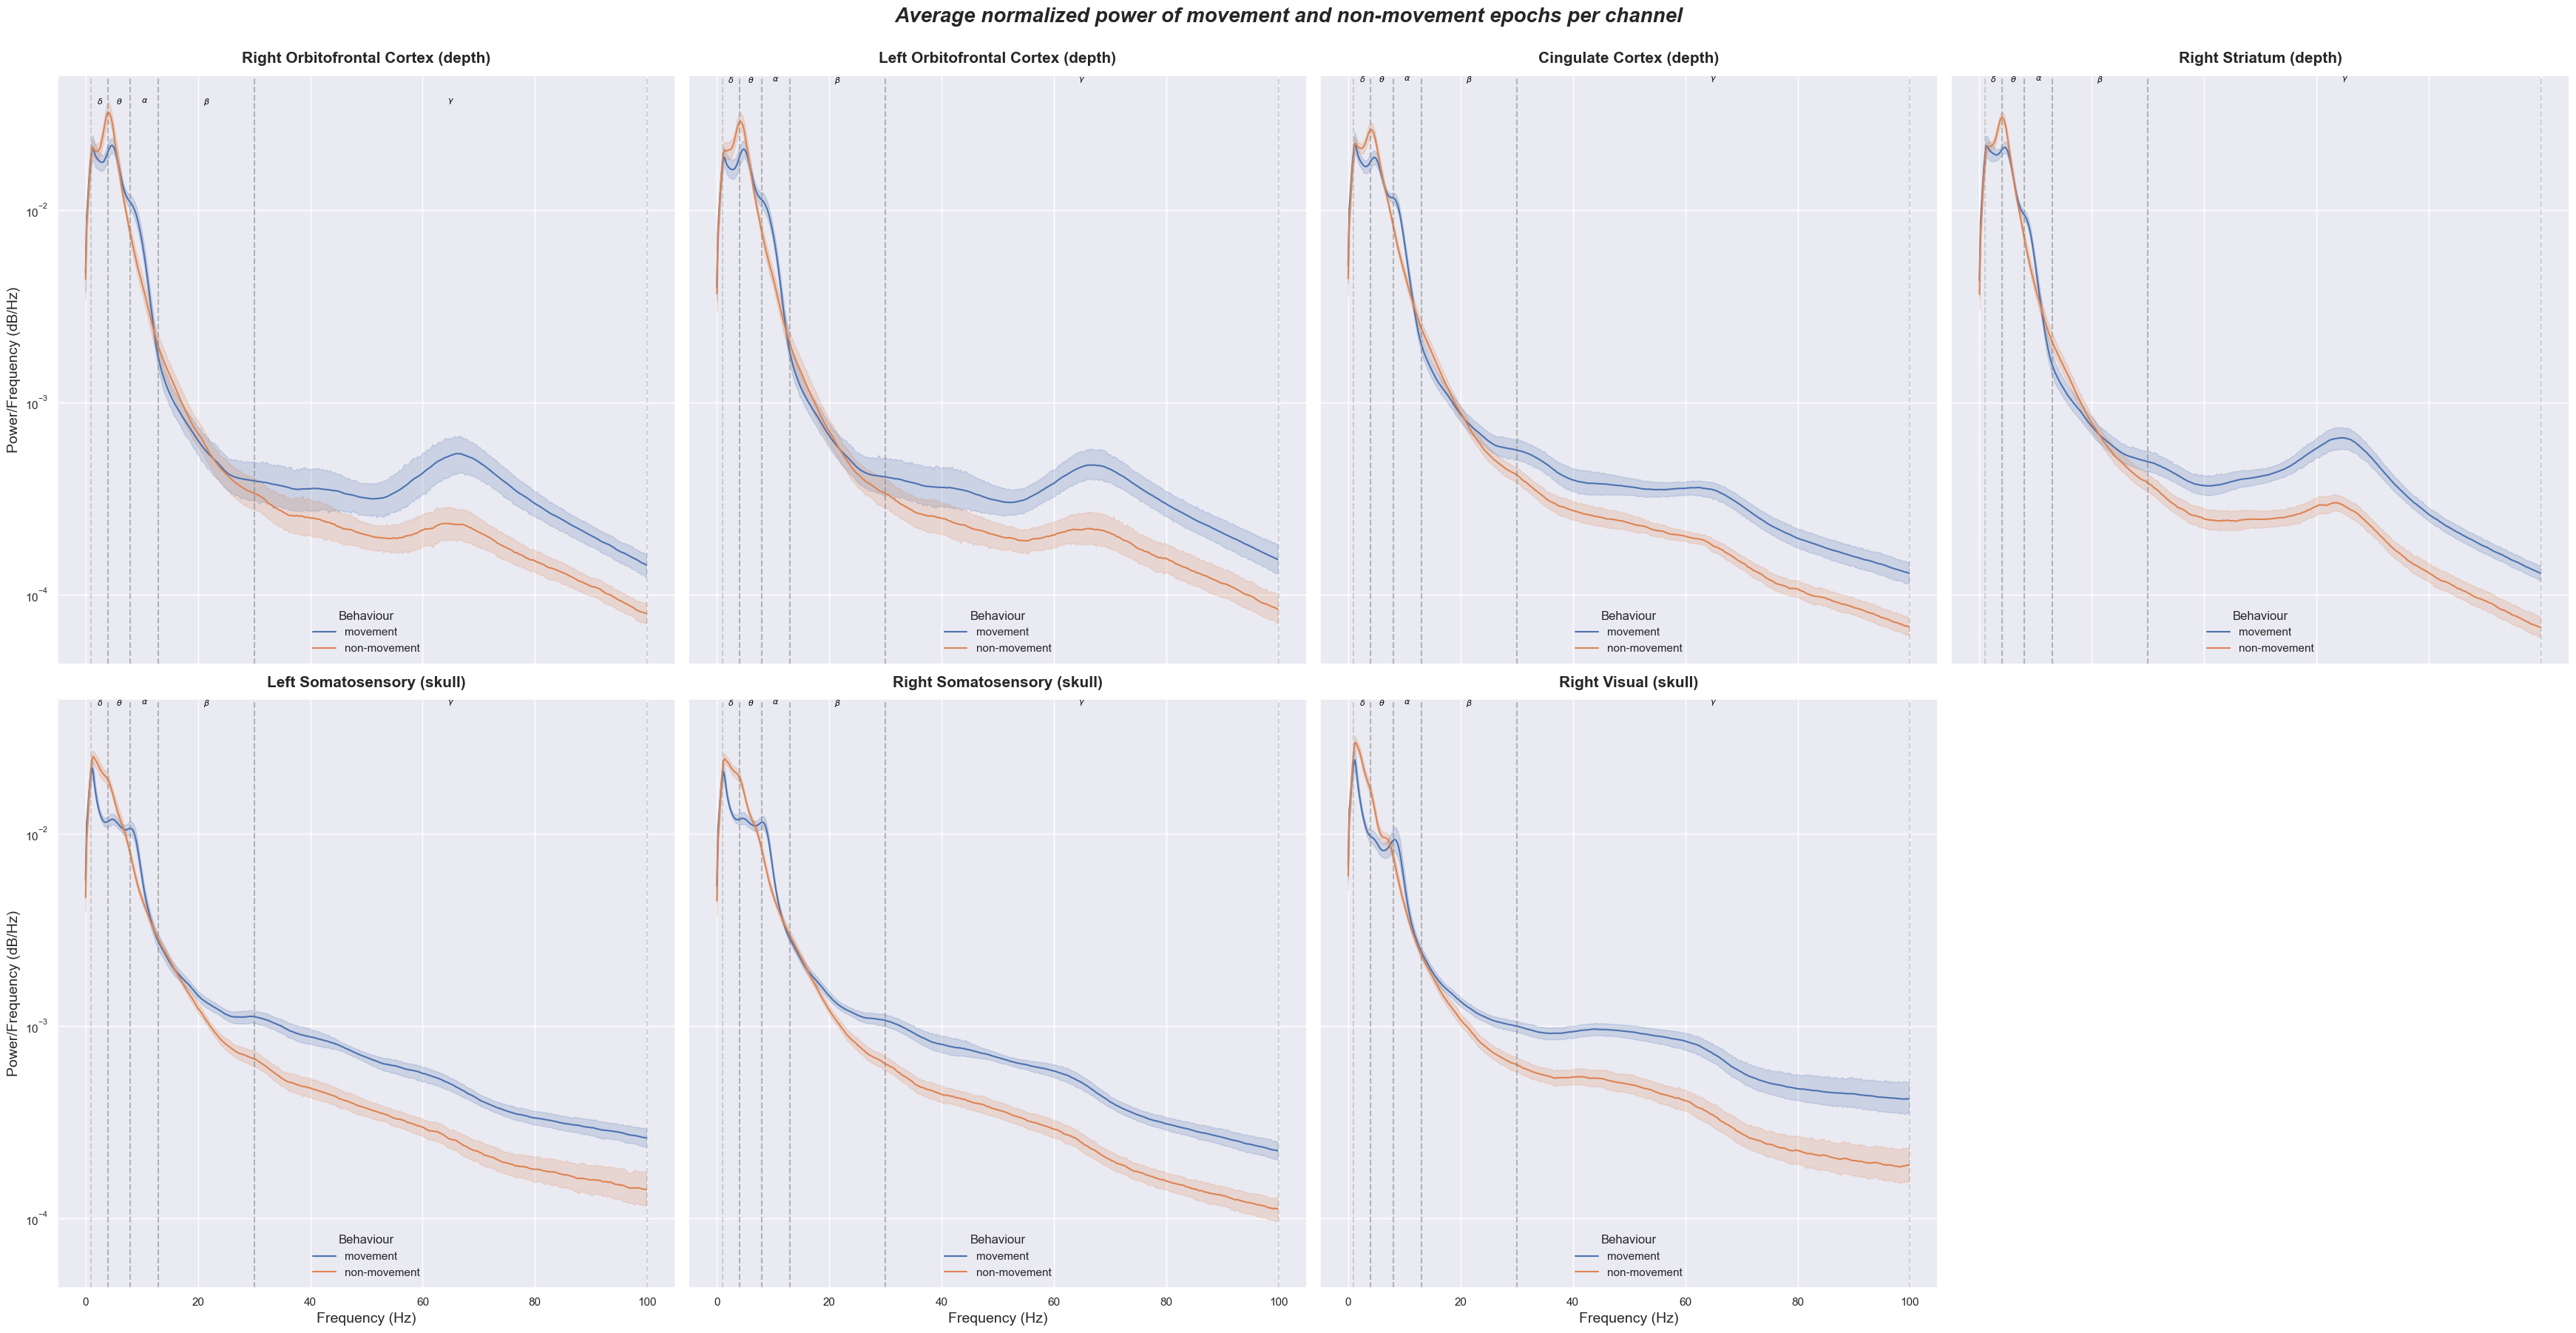

In [26]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="behaviour", legend=True, ax=axs[i], errorbar=('ci', 95))
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)', fontsize=14)
    axs[i].set_ylabel('Power/Frequency (dB/Hz)', fontsize=14)
    axs[i].set_title(channel_name_dict[channel], fontsize=15, fontweight='bold', y=1.01)
    axs[i].legend(title='Behaviour', frameon=False)

plt.suptitle(f'Average normalized power of movement and non-movement epochs per channel', fontsize=20, fontweight='bold', fontstyle='italic', y=1)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, "mov_vs_nonmov_norm_power_averages.pdf"))

Resting and sleep are associated with slow waves (delta, theta and alpha), which is beautifully visualized here. Movement epochs have a lower power in the lower frequency bands, and higher power in the beta and gamma bands than the non-movement epochs.